# 파이프라인 소개

1. Load and check data
    - load data
    - outlier detection
    - joining train and test set
    - check for null and missing values
    
2. Feature analysis
    - Numerical values
    - Categorical values
    
3. Filling missing Values
    - Age
    
4. Feature engineering
    - Name/Title
    - Family Size
    - Cabin
    - Ticket
    
5. Modeling
    - Simple modeling
        - Cross validation models
        - Hyperparamater tunning for best models
        - Plot learning curves
        - Feature importance of the tree based classifiers
    - Ensemble modeling
        - Combining models
    - Prediction
        - Predict and Submit results

# 라이브러리 로드

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

from collections import Counter

from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, GradientBoostingClassifier, ExtraTreesClassifier, VotingClassifier
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.svm import SVC
from sklearn.model_selection import GridSearchCV, cross_val_score, StratifiedKFold, learning_curve

sns.set(style='white', context='notebook', palette='deep')

# Load and check data

## Load data

In [2]:
# Load data

train = pd.read_csv('../data/titanic/train.csv')
test = pd.read_csv('../data/titanic/test.csv')
IDtest = test['PassengerId']

## Outlier detection

In [3]:
# Outlier detection 

def detect_outliers(df,n,features):
    """
    Takes a dataframe df of features and returns a list of the indices
    corresponding to the observations containing more than n outliers according
    to the Tukey method.
    """
    outlier_indices = []
    
    # iterate over features(columns)
    for col in features:
        # 1st quartile (25%)
        Q1 = np.percentile(df[col], 25)
        # 3rd quartile (75%)
        Q3 = np.percentile(df[col],75)
        # Interquartile range (IQR)
        IQR = Q3 - Q1
        
        # outlier step
        outlier_step = 1.5 * IQR
        
        # Determine a list of indices of outliers for feature col
        outlier_list_col = df[(df[col] < Q1 - outlier_step) | (df[col] > Q3 + outlier_step )].index
        
        # append the found outlier indices for col to the list of outlier indices 
        outlier_indices.extend(outlier_list_col)
        
    # select observations containing more than 2 outliers
    outlier_indices = Counter(outlier_indices)        
    multiple_outliers = list( k for k, v in outlier_indices.items() if v > n )
    
    return multiple_outliers   


In [4]:
# detect outliers from Age, SibSp, Parch and Fare
Outliers_to_drop = detect_outliers(train, 2, ['Age', 'SibSp', 'Parch', 'Fare'])

In [5]:
train.loc[Outliers_to_drop] # Show the outliers rows

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
27,28,0,1,"Fortune, Mr. Charles Alexander",male,19.0,3,2,19950,263.00,C23 C25 C27,S
88,89,1,1,"Fortune, Miss. Mabel Helen",female,23.0,3,2,19950,263.00,C23 C25 C27,S
159,160,0,3,"Sage, Master. Thomas Henry",male,NaN,8,2,CA. 2343,69.55,NaN,S
180,181,0,3,"Sage, Miss. Constance Gladys",female,NaN,8,2,CA. 2343,69.55,NaN,S
201,202,0,3,"Sage, Mr. Frederick",male,NaN,8,2,CA. 2343,69.55,NaN,S
324,325,0,3,"Sage, Mr. George John Jr",male,NaN,8,2,CA. 2343,69.55,NaN,S
341,342,1,1,"Fortune, Miss. Alice Elizabeth",female,24.0,3,2,19950,263.00,C23 C25 C27,S
792,793,0,3,"Sage, Miss. Stella Anna",female,NaN,8,2,CA. 2343,69.55,NaN,S
846,847,0,3,"Sage, Mr. Douglas Bullen",male,NaN,8,2,CA. 2343,69.55,NaN,S
863,864,0,3,"Sage, Miss. Dorothy Edith ""Dolly""",female,NaN,8,2,CA. 2343,69.55,NaN,S


- 10개의 아웃라이어를 발견했음.

- 22, 89, 342는 Fare 이 높음

- 나머지 7개는 SibSp 가 높음

## joining train and test set

In [6]:
# Join train and test datasets in order to obtain teh same number of features during categorical conversion
train_len = len(train)
dataset = pd.concat(objs=[train, test], axis=0).reset_index(drop=True)

## check for null and missing values

In [7]:
# Fill empty and NaNs values with NaN
dataset = dataset.fillna(np.nan)

# Check for Null values
dataset.isnull().sum()

PassengerId       0
Survived        418
Pclass            0
Name              0
Sex               0
Age             263
SibSp             0
Parch             0
Ticket            0
Fare              1
Cabin          1014
Embarked          2
dtype: int64

- Age + Cabin이 상당한 NaN을 가지고 있다는 사실을 알 수 있음.

- 이를 처리하는 방법이 상당히 중요함.

In [8]:
# Infos
train.info()
train.isnull().sum()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  891 non-null    int64  
 1   Survived     891 non-null    int64  
 2   Pclass       891 non-null    int64  
 3   Name         891 non-null    object 
 4   Sex          891 non-null    object 
 5   Age          714 non-null    float64
 6   SibSp        891 non-null    int64  
 7   Parch        891 non-null    int64  
 8   Ticket       891 non-null    object 
 9   Fare         891 non-null    float64
 10  Cabin        204 non-null    object 
 11  Embarked     889 non-null    object 
dtypes: float64(2), int64(5), object(5)
memory usage: 83.7+ KB


PassengerId      0
Survived         0
Pclass           0
Name             0
Sex              0
Age            177
SibSp            0
Parch            0
Ticket           0
Fare             0
Cabin          687
Embarked         2
dtype: int64

In [9]:
train.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [10]:
train.dtypes

PassengerId      int64
Survived         int64
Pclass           int64
Name            object
Sex             object
Age            float64
SibSp            int64
Parch            int64
Ticket          object
Fare           float64
Cabin           object
Embarked        object
dtype: object

In [11]:
## Summarize data
# Summarize and statistics
train.describe()

,PassengerId,Survived,Pclass,Age,SibSp,Parch,Fare
count,891.000000,891.000000,891.000000,714.000000,891.000000,891.000000,891.000000
mean,446.000000,0.383838,2.308642,29.699118,0.523008,0.381594,32.204208
std,257.353842,0.486592,0.836071,14.526497,1.102743,0.806057,49.693429
min,1.000000,0.000000,1.000000,0.420000,0.000000,0.000000,0.000000
25%,223.500000,0.000000,2.000000,20.125000,0.000000,0.000000,7.910400
50%,446.000000,0.000000,3.000000,28.000000,0.000000,0.000000,14.454200
75%,668.500000,1.000000,3.000000,38.000000,1.000000,0.000000,31.000000
max,891.000000,1.000000,3.000000,80.000000,8.000000,6.000000,512.329200


# Feature analysis

## Numerical values

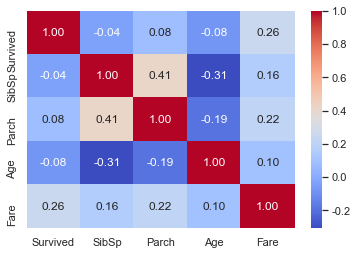

In [12]:
# Corrleation matrix between numerical values (SibSp Parch Age and Fare values) and Survived
g = sns.heatmap(train[['Survived', 'SibSp', 'Parch', 'Age', 'Fare']].corr(), annot=True, fmt='.2f', cmap='coolwarm')

- Fare 만이 Survived 만이 상관관계를 어느정도 가지고 있음.

- 그렇다고 다른 feature가 필요 없다는 것은 아님. 시각화를 통해서 자세하게 분석을 해야됨.

### SibSp

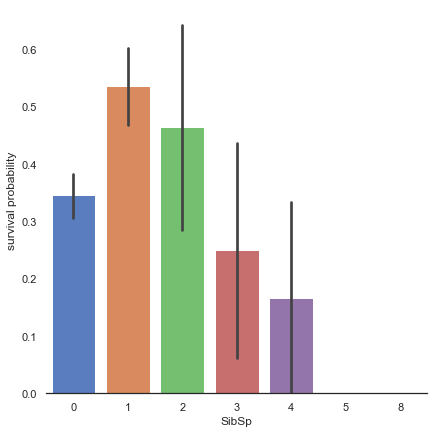

In [13]:
# Explore SibSp feature vs Survived
g = sns.catplot(x='SibSp', y='Survived', data=train, kind='bar', height=6, palette='muted')
g.despine(left=True)
g = g.set_ylabels('survival probability')

- 형제 자매/ 배우자가 많은 승객은 생존율이 낮음.

- 단일 승객(0 SibSP) 또는 1~2명정도 함께 있는 승객의 경우 생존율이 높음.

- 이것을 통해서 새로운 feature를 만들 수 있지 않을까? 이 부분을 데이터를 보면서 파악 해야됨.

### Parch

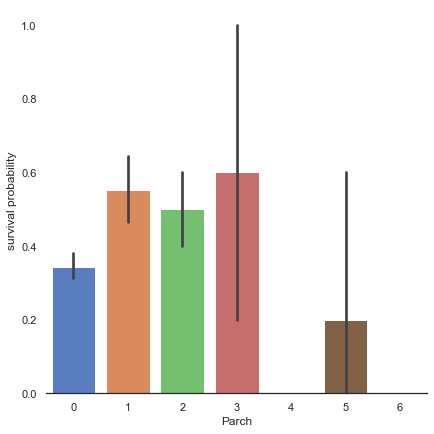

In [14]:
# Explore Parch feature vs Survived
g = sns.catplot(x='Parch', y='Survived', data=train, kind='bar', height=6, palette='muted')
g.despine(left=True)
g = g.set_ylabels('survival probability')

- 가족의 수가 적은 경우가 혼자일 때보다(Parch 0), 적당히 있을 때보다(Parch 3,4), 많이 있을 때 보다(Parch 5,6) 생존율이 높음.

- Parch 3인 경우에는 편차가 커서, 이를 주의깊게 볼 필요가 있음.

### Age

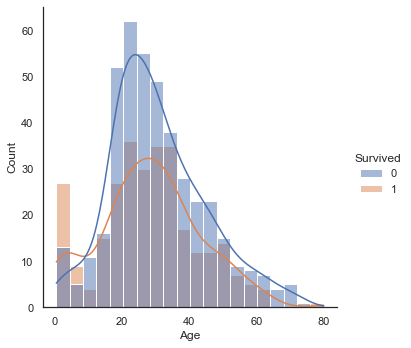

In [15]:
# Explore Age vs Survived

sns.displot(data=train, x='Age', hue='Survived', kind='hist', kde=True)
plt.show()

- Age는 tailed distribution 의 형태를 띄고 있음. tailed distribtuion은 정규분포에 비해 극한 상황에서의 확률이 더 높은 분포를 말함.

- 생존한 집단과 생존하지 않은 집단간의 연령 분포가 동일하지 않을 것을 볼 수 있음.

- 젊은 사람들이 생존율이 높고, 60~80세 사이의 사람들은 생존율이 낮다는 것을 알 수 있음.

- 그리고 아주 어린 승객일 경우, 생존율이 다른 나이대에 비해 상대적으로 높음

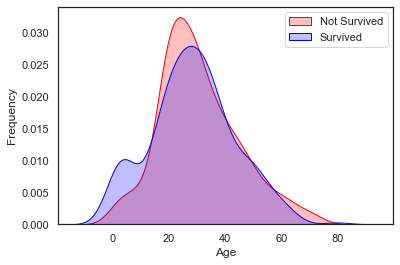

In [16]:
# Explore Age distribution
g = sns.kdeplot(train['Age'][(train['Survived'] == 0) & (train['Age'].notnull())], color='Red', shade=True)
g = sns.kdeplot(train['Age'][(train['Survived'] == 1) & (train['Age'].notnull())], ax=g, color='Blue', shade=True)
g.set_xlabel('Age')
g.set_ylabel('Frequency')
g = g.legend(['Not Survived', 'Survived'])

- 2개를 겹쳐서보면, 아기와 아주 어린 아이들의 경우(0~15), 최댓값(peak)을 가진다는 사실을 알 수 있음.

### Fare

In [17]:
dataset['Fare'].isnull().sum()

1

In [18]:
# Fill Fare missing values with the median value
dataset['Fare'] = dataset['Fare'].fillna(dataset['Fare'].median())

- 1개의 결측치를 예측에 중요한 영향을 끼치지 않게 하기 위해서 Fare의 중간값으로 채움

/Users/morphine/.pyenv/versions/anaconda3-5.3.1/envs/py37/lib/python3.7/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


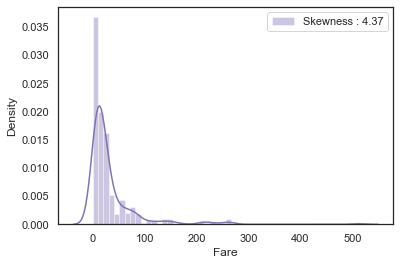

In [19]:
# Explore Fare distribution 
g = sns.distplot(dataset["Fare"], color="m", label="Skewness : %.2f"%(dataset["Fare"].skew()))
g = g.legend(loc="best")

- Fare은 한쪽으로 치우쳐져 있는 분포를 따르고 있음. 모델에서 높은 Fare에 대해서 가중치를 많이 주게 됨. 모델이 적절하게 학습하기 힘듬.

- log function을 이용해서 한쪽으로 치우쳐져 있는 분포를 어느정도 억제할 필요가 있음.

In [20]:
# Apply log to Fare to reduce skewness distribution
dataset['Fare'] = dataset['Fare'].map(lambda i: np.log(i) if i > 0 else 0)

/Users/morphine/.pyenv/versions/anaconda3-5.3.1/envs/py37/lib/python3.7/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


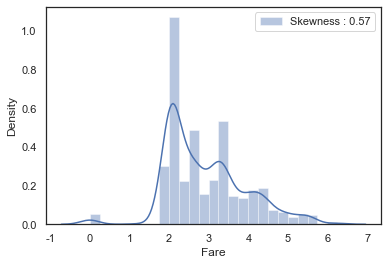

In [21]:
g = sns.distplot(dataset["Fare"], color="b", label="Skewness : %.2f"%(dataset["Fare"].skew()))
g = g.legend(loc="best")

## Categorical values

### Sex

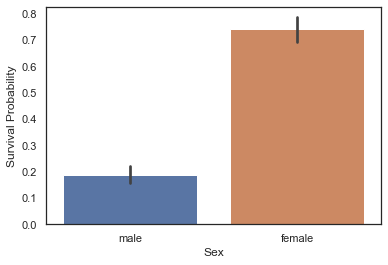

In [22]:
g = sns.barplot(x='Sex', y='Survived', data=train)
g = g.set_ylabel('Survival Probability')

In [23]:
train[['Sex', 'Survived']].groupby('Sex').mean()

,Survived
Sex,
female,0.742038
male,0.188908


- 남성이 여성보다 생존율이 낮다는 것을 알 수 있음. Sex는 생존예측에 중요한 feature 일수도?

- Women and Children first policy 에 의해서 생존율이 높을 가능성이 있음.

### Pclass

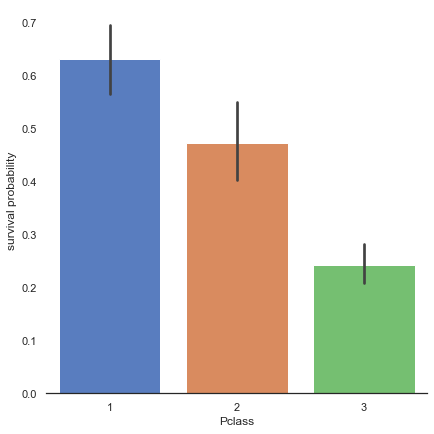

In [24]:
# Explore Pclass vs Survived
g = sns.catplot(x='Pclass', y='Survived', data=train, kind='bar', height=6, palette='muted')
g.despine(left=True)
g = g.set_ylabels('survival probability')

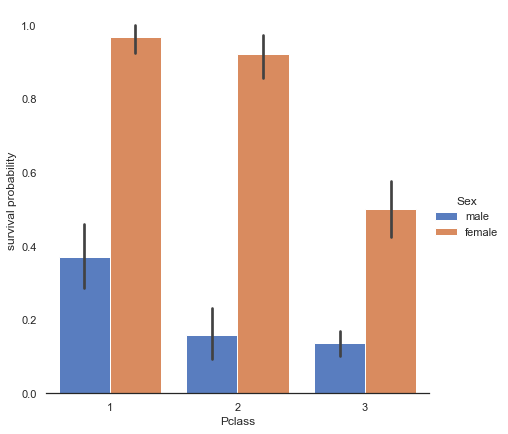

In [25]:
# Explore Pclass vs Survived by Sex
g = sns.catplot(x='Pclass', y='Survived', hue='Sex', data=train, height=6, kind='bar', palette='muted')
g.despine(left=True)
g = g.set_ylabels('survival probability')

- 생존율이 Pclass마다 다르다. 1등석 승객과 2등석 승객은 생존율이 높지만, 3등석 승객은 생존율이 낮음.

### Embarked

In [26]:
dataset['Embarked'].isnull().sum()

2

In [27]:
# Fill Embarked nan values of dataset set with 'S' most frequent value
dataset['Embarked'] = dataset['Embarked'].fillna('S')

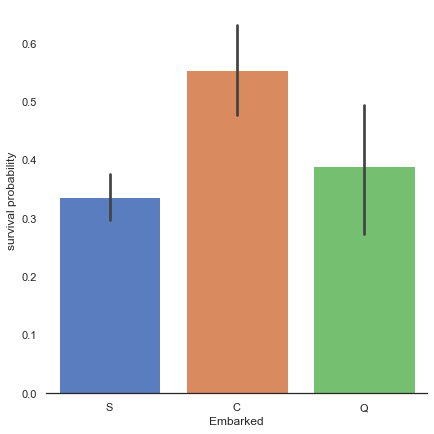

In [28]:
# Explore Embarked vs Survived
g = sns.catplot(x='Embarked', y='Survived', data=train, height=6, kind='bar', palette='muted')
g.despine(left=True)
g = g.set_ylabels('survival probability')

- 항구 C에서 탑승한 손님이 더 생존율이 높음

- 그 이유는 항구 C에서 탑승한 손님의 대다수가 Pclass 1이기 때문이라고 생각할 수 있음.

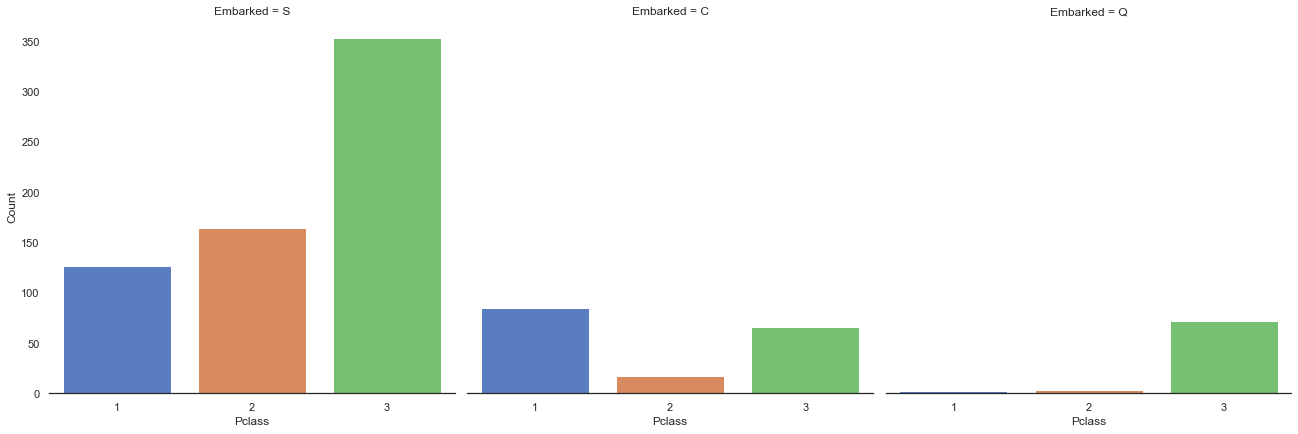

In [29]:
# Explore Pclass vs Embarked
g = sns.catplot(x='Pclass', col='Embarked', data=train, height=6, kind='count', palette='muted')
g.despine(left=True)
g = g.set_ylabels('Count')

- 항구 S, Q의 경우 대다수의 승객이 3등석임. 반면 항구 C의 경우 대다수의 승객이 1등석이기 때문에 상대적으로 생존율이 높다는 것을 알 수 있음.

- 왜 높은지는 알 수 없지만, 1등석 승객이 대피 우선순위가 높았지 않았을 까라고 추측할 수 있음.

# Filling missing Values

## Age

- Age 에는 256개의 결측치 값이 존재

- 특정 하위 분포에 생존율이 더 높음 (어린이 같은 경우)

- 따라서 Age의 특성을 유지하고 결측치를 처리하는 것이 중요.

- 그래서 Age와 연관된 feature를 보는 것이 중요. (Sex, Parch, Pclass and SibSP)

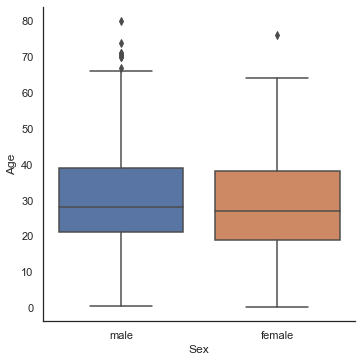

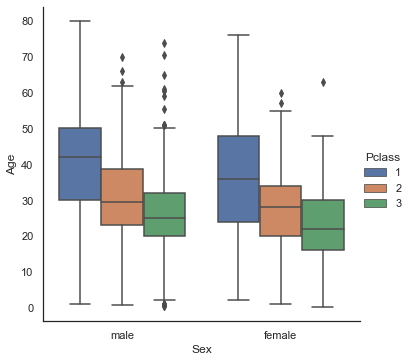

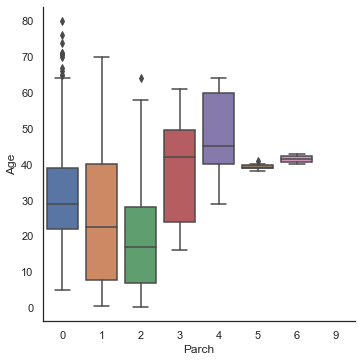

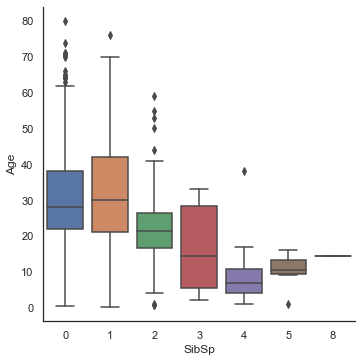

In [30]:
# Explore Agevs Sex, Parch, Pclass and SibSP
g = sns.catplot(y='Age', x='Sex', data=dataset, kind='box')
g = sns.catplot(y='Age', x='Sex', hue='Pclass', data=dataset, kind='box')
g = sns.catplot(y='Age', x='Parch', data=dataset, kind='box')
g = sns.catplot(y='Age', x='SibSp', data=dataset, kind='box')

- 남성과 여성은 나이 분포는 비슷. 나이에 대한 결측치를 처리할 때 성별을 이용하는 것은 좋지 않음.

- Pclass의 경우, 1등석, 2등석, 3등석별로 나이 분포가 다름.

- Parch가 크면 클수록 나이가 많고, SibSp가 크면 클수록 나이가 적음.

In [31]:
# convert Sex into categorical value 0 for male and 1 for female
dataset['Sex'] = dataset['Sex'].map({'male':0, 'female':1})

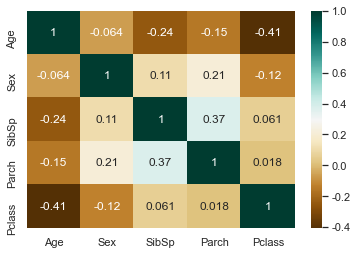

In [32]:
g = sns.heatmap(dataset[['Age', 'Sex', 'SibSp', 'Parch', 'Pclass']].corr(), cmap='BrBG', annot=True)

- Age는 Sex와 상관없지만, Pclass, Parch, SibSp와 음의 상관 관계가 있음.

- Parch를 가지고 Age를 확인했을 때, Parch가 증가함에 따라 나이가 증가했지만, 상관관계에서는 음의 상관 관계를 가지고 있음.

- Age에 대한 결측치를 채우는 아이디어는 Pclass, Parch, SibSp에 따라 비슷한 행 중간값을 채우는 것.

In [33]:
# Filling missing value of Age

## Fill Age with the median age of similar rows according to Pclass, Parch and SibSp
# Index of NaN age rows
index_NaN_age = list(dataset['Age'][dataset['Age'].isnull()].index)

for i in index_NaN_age:
    age_med = dataset['Age'].median()
    age_pred = dataset.Age[(dataset.SibSp == dataset.iloc[i].SibSp) & (dataset.Parch == dataset.iloc[i].Parch) & (dataset.Pclass == dataset.iloc[i].Pclass)].median()
    if not np.isnan(age_pred):
        dataset.Age.iat[i] = age_pred
    else:
        dataset.Age.iat[i] = age_med

/Users/morphine/.pyenv/versions/anaconda3-5.3.1/envs/py37/lib/python3.7/site-packages/numpy/lib/nanfunctions.py:1111: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis, out=out, keepdims=keepdims)


In [34]:
dataset.Age.isnull().sum()

0

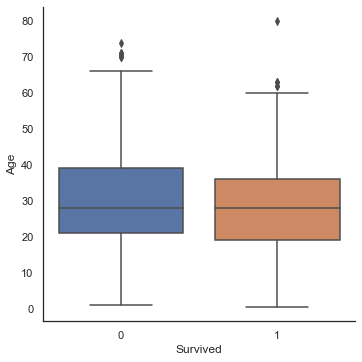

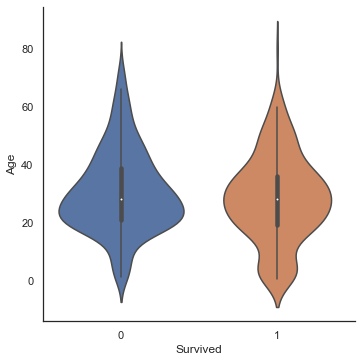

In [35]:
g = sns.catplot(x='Survived', y='Age', data=train, kind='box')
g = sns.catplot(x='Survived', y='Age', data=train, kind='violin')

- box plot을 통해서 생존자와 사망자에 대한 중간값은 별다른게 없음.

- 하지만, violin plot에서는 아주 어린 승객의 경우 생존율이 더 높다는 것을 알 수 있음.

# Feature engineering

## 5.1 Name/Title

In [36]:
dataset['Name'].head()

0                              Braund, Mr. Owen Harris
1    Cumings, Mrs. John Bradley (Florence Briggs Th...
2                               Heikkinen, Miss. Laina
3         Futrelle, Mrs. Jacques Heath (Lily May Peel)
4                             Allen, Mr. William Henry
Name: Name, dtype: object

- Name feature에는 승객의 호칭 정보가 담겨 있음.

- 호칭에 따라 대피 우선순위가 바뀔 수 있음. 따라서 모델에 해당 정보를 추가하는 것이 도움이 될 수 있음.

In [37]:
# Get title from Name
dataset_title = [i.split(",")[1].split('.')[0].strip() for i in dataset.Name]
dataset['Title'] = pd.Series(dataset_title)
dataset['Title'].head()

0      Mr
1     Mrs
2    Miss
3     Mrs
4      Mr
Name: Title, dtype: object

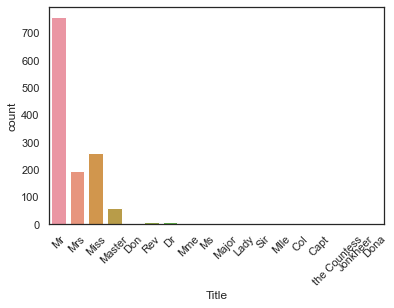

In [38]:
g = sns.countplot(x='Title', data=dataset)
g = plt.setp(g.get_xticklabels(), rotation=45)

- 17개의 호칭이 있고, 4개를 제외하고, 나머지 호칭들은 거의 없음

In [39]:
# Convert to categorical values Title 
dataset["Title"] = dataset["Title"].replace(['Lady', 'the Countess','Countess','Capt', 'Col','Don', 'Dr', 'Major', 'Rev', 'Sir', 'Jonkheer', 'Dona'], 'Rare')
dataset["Title"] = dataset["Title"].map({"Master":0, "Miss":1, "Ms" : 1 , "Mme":1, "Mlle":1, "Mrs":1, "Mr":2, "Rare":3})
dataset["Title"] = dataset["Title"].astype(int)

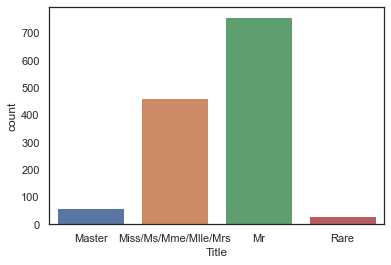

In [40]:
g = sns.countplot(x=dataset['Title'])
g = g.set_xticklabels(['Master', 'Miss/Ms/Mme/Mlle/Mrs', 'Mr', 'Rare'])

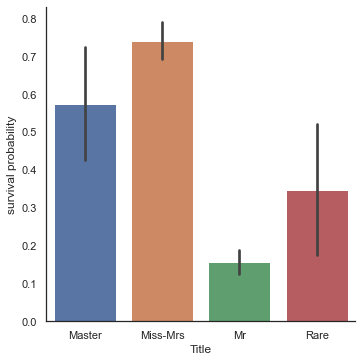

In [41]:
g = sns.catplot(x='Title', y='Survived', data=dataset, kind='bar')
g = g.set_xticklabels(['Master', 'Miss-Mrs', 'Mr', 'Rare'])
g = g.set_ylabels('survival probability')

- 여성과 아동 우선정책 때문에 Master와 Miss-Mrs 호칭을 가진 승객이 생존율이 높음.

- 그리고 남성은 낮음.

- 희귀한 호칭을 가진 승객의 경우, 생존율이 생각보다 높음.

In [42]:
# Drop Name variable
dataset.drop(labels = ['Name'], axis=1, inplace=True)

## Family Size

- 대피할 때, 자신의 가족을 찾기 때문에 대가족의 경우 생존율이 낮다고 상상할 수 있음.

- 그래서 가족 구성원의 수를 새로운 feature로 사용하는 것이 생존예측에 타당함.

- SibSp + Parch + 1(자기자신)을 통해서 Fize(가족 구성원 수)라는 새로운 feature를 만듬

In [43]:
# Create a family size descriptor from SibSp and Parch
dataset['Fsize'] = dataset['SibSp'] + dataset['Parch'] + 1

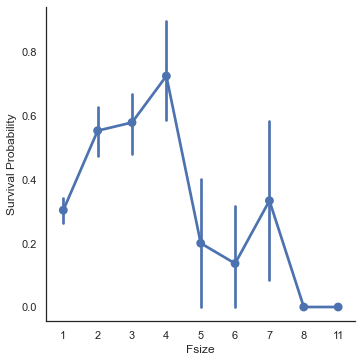

In [44]:
g = sns.catplot(x='Fsize', y='Survived', data=dataset, kind='point')
g = g.set_ylabels('Survival Probability')

- 가족 구성원의 수가 중요한 역할을 하는 것처럼 보임. 대 가족의 경우 생존화률이 낮다는 것을 알 수 있음.

- 그리고 추가적으로 가족 구성원의 수를 가지고 4가지의 범주형 데이터를 만들 수 있음.

In [45]:
# Creatte new feature of family size
dataset['Single'] = dataset['Fsize'].map(lambda s: 1 if s == 1 else 0)
dataset['SmallF'] = dataset['Fsize'].map(lambda s: 1 if s == 2 else 0)
dataset['MedF'] = dataset['Fsize'].map(lambda s: 1 if 3 <= s <= 4 else 0)
dataset['LargeF'] = dataset['Fsize'].map(lambda s: 1 if s>= 5 else 0)

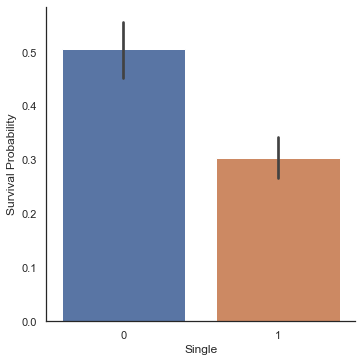

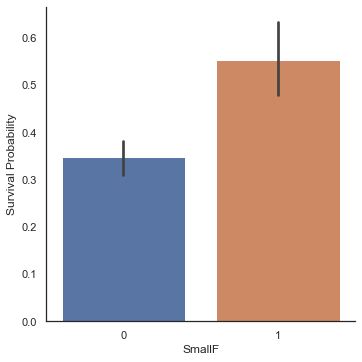

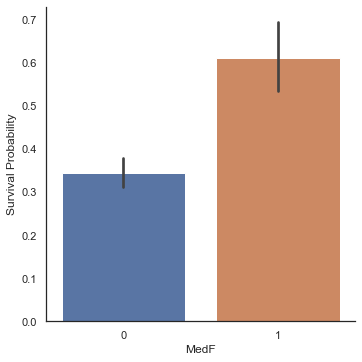

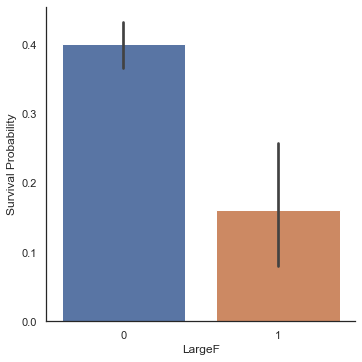

In [46]:
g = sns.catplot(x='Single', y='Survived', data=dataset, kind='bar')
g = g.set_ylabels('Survival Probability')

g = sns.catplot(x='SmallF', y='Survived', data=dataset, kind='bar')
g = g.set_ylabels('Survival Probability')

g = sns.catplot(x='MedF', y='Survived', data=dataset, kind='bar')
g = g.set_ylabels('Survival Probability')

g = sns.catplot(x='LargeF', y='Survived', data=dataset, kind='bar')
g = g.set_ylabels('Survival Probability')

- 가족 구성원의 수에 따른 4개의 범주를 봤을 때, Small, Medium의 경우 생존율이 Single, Large의 경우보다 높음

In [47]:
# convert to indicator values Title and Embarked
dataset = pd.get_dummies(dataset, columns=['Title'])
dataset = pd.get_dummies(dataset, columns=['Embarked'], prefix='Em')

In [48]:
dataset.head()

,PassengerId,Survived,Pclass,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,...,SmallF,MedF,LargeF,Title_0,Title_1,Title_2,Title_3,Em_C,Em_Q,Em_S
0,1,0.0,3,0,22.0,1,0,A/5 21171,1.981001,NaN,...,1,0,0,0,0,1,0,0,0,1
1,2,1.0,1,1,38.0,1,0,PC 17599,4.266662,C85,...,1,0,0,0,1,0,0,1,0,0
2,3,1.0,3,1,26.0,0,0,STON/O2. 3101282,2.070022,NaN,...,0,0,0,0,1,0,0,0,0,1
3,4,1.0,1,1,35.0,1,0,113803,3.972177,C123,...,1,0,0,0,1,0,0,0,0,1
4,5,0.0,3,0,35.0,0,0,373450,2.085672,NaN,...,0,0,0,0,0,1,0,0,0,1


## Cabin

In [49]:
dataset.Cabin.head()

0     NaN
1     C85
2     NaN
3    C123
4     NaN
Name: Cabin, dtype: object

In [50]:
dataset.Cabin.describe()

count             295
unique            186
top       C23 C25 C27
freq                6
Name: Cabin, dtype: object

In [51]:
dataset.Cabin.isnull().sum()

1014

- 295개의 데이터가 존재하고, 1014개의 결측치값이 존재.

- 객실 정보가 없는 승객의 경우, NaN값으로 두는 것이 아니라 객실 정보가 없다고 표시.

In [52]:
# Replace the Cabin number by the type of cabin 'X' if not
dataset['Cabin'] = pd.Series([i[0] if not pd.isnull(i) else 'X' for i in dataset['Cabin']])

- cabind의 첫 문자는 프러트(Desk)를 의미함. 타이타닉에서 승객의 위치 정보를 가지고 있음.

- 따라서, 호번호를 지우고, 포괄적인 위치 정보만 남김. Cabin을 통해서 승객의 위치 정보를 어느정도 반영할 수 있음.

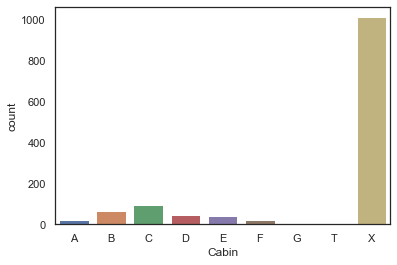

In [53]:
g = sns.countplot(x=dataset["Cabin"],order=['A','B','C','D','E','F','G','T','X'])

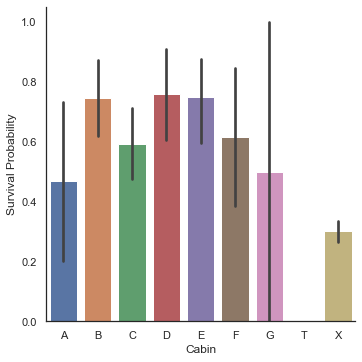

In [54]:
g = sns.catplot(y='Survived', x='Cabin', data=dataset, kind='bar', order=['A', 'B', 'C', 'D', 'E', 'F', 'G', 'T', 'X'])
g = g.set_ylabels('Survival Probability')

객실이있는 승객 수가 적기 때문에 생존 확률은 중요한 표준 편차를 가지며 다른 책상에있는 승객의 생존 확률을 구분할 수 없습니다.

그러나 우리는 일반적으로 객실이있는 승객이 (X)가없는 승객보다 생존 가능성이 더 높다는 것을 알 수 있습니다.

특히 객실 B, C, D, E 및 F에 해당됩니다.

- 객실이 있는 승객의 수가 적기 때문에 생존율은 중요한 표준 편차를 가지고 있고, 프런트에 따른 생존율은 구분할 수 없음.

- 일반적으로 객실 정보가 있는 승객이 객실 정보가 업슨 승객보다 생존율이 높다는 것을 알 수 있음. (T의 경우 제외)

- B, C, D, E, F의 경우는 생존율이 50%가 넘음.

In [55]:
dataset = pd.get_dummies(dataset, columns=['Cabin'], prefix='Cabin')

## Ticket

In [56]:
dataset.Ticket.head()

0           A/5 21171
1            PC 17599
2    STON/O2. 3101282
3              113803
4              373450
Name: Ticket, dtype: object

- 동일한 접두사를 가지고 있는 티겟은 동일한 객실에 대해 에약 될 수 있음을 의미함. 따라서 티겟을 통해서 선실내의 객실에 대한 실제 배치를 파악할 수 있음.

- 그리고 동일한 접두사를 가지고 잇는 티겟은 비슷한 Pclass와 비슷한 생존율을 가지고 있음.

- 따라서 티겟의 접두사를 정보로 쓰는 것이 생존율 예측에 도움이 될 수 있음.

In [57]:
## Treat Ticket by extracting the ticket prefix. When there is no prefix it returns X. 

Ticket = []
for i in list(dataset.Ticket):
    if not i.isdigit() :
        Ticket.append(i.replace(".","").replace("/","").strip().split(' ')[0]) #Take prefix
    else:
        Ticket.append("X")

dataset.Ticket = Ticket
dataset.Ticket.head()

0        A5
1        PC
2    STONO2
3         X
4         X
Name: Ticket, dtype: object

In [58]:
dataset = pd.get_dummies(dataset, columns = ['Ticket'], prefix='T')

In [59]:
# Create categorical values for Pclass
dataset['Pclass'] = dataset['Pclass'].astype('category')
dataset = pd.get_dummies(dataset, columns = ['Pclass'], prefix='Pc')

In [60]:
# Drop useless variables
dataset.drop(labels = ['PassengerId'], axis=1, inplace=True)

In [61]:
dataset.head()

,Survived,Sex,Age,SibSp,Parch,Fare,Fsize,Single,SmallF,MedF,...,T_STONO,T_STONO2,T_STONOQ,T_SWPP,T_WC,T_WEP,T_X,Pc_1,Pc_2,Pc_3
0,0.0,0,22.0,1,0,1.981001,2,0,1,0,...,0,0,0,0,0,0,0,0,0,1
1,1.0,1,38.0,1,0,4.266662,2,0,1,0,...,0,0,0,0,0,0,0,1,0,0
2,1.0,1,26.0,0,0,2.070022,1,1,0,0,...,0,1,0,0,0,0,0,0,0,1
3,1.0,1,35.0,1,0,3.972177,2,0,1,0,...,0,0,0,0,0,0,1,1,0,0
4,0.0,0,35.0,0,0,2.085672,1,1,0,0,...,0,0,0,0,0,0,1,0,0,1


# MODELING

In [62]:
## Separate train dataset and test dataset

train = dataset[:train_len].copy()
test = dataset[train_len:].copy()
test.drop(labels=['Survived'], axis=1, inplace=True)

In [63]:
## Separate train features and label

train['Survived'] = train['Survived'].astype(int)

Y_train = train['Survived']
X_train = train.drop(labels = ['Survived'], axis=1)

### Cross validate models

10가지 모델에 대해서 교차 검증하기

- SVC
- Decision Tree
- AdaBoost
- Random Forest
- Extra Trees
- Gradient Boosting
- Multiple layer perceptron (neural network)
- KNN
- Logistic regression
- Linear Discriminant Analysis

In [64]:
# Cross validate model with Kfold stratified cross val
kfold = StratifiedKFold(n_splits=10)

/Users/morphine/.pyenv/versions/anaconda3-5.3.1/envs/py37/lib/python3.7/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


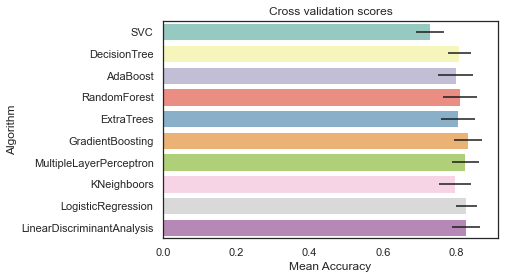

In [65]:
# Modeling step Test differents algorithms
random_state = 42
classifiers = []
classifiers.append(SVC(random_state=random_state))
classifiers.append(DecisionTreeClassifier(random_state=random_state))
classifiers.append(AdaBoostClassifier(DecisionTreeClassifier(random_state=random_state),random_state=random_state,learning_rate=0.1))
classifiers.append(RandomForestClassifier(random_state=random_state))
classifiers.append(ExtraTreesClassifier(random_state=random_state))
classifiers.append(GradientBoostingClassifier(random_state=random_state))
classifiers.append(MLPClassifier(random_state=random_state))
classifiers.append(KNeighborsClassifier())
classifiers.append(LogisticRegression(random_state = random_state))
classifiers.append(LinearDiscriminantAnalysis())

cv_results = []
for classifier in classifiers :
    cv_results.append(cross_val_score(classifier, X_train, y = Y_train, scoring = "accuracy", cv = kfold, n_jobs=4))

cv_means = []
cv_std = []
for cv_result in cv_results:
    cv_means.append(cv_result.mean())
    cv_std.append(cv_result.std())

cv_res = pd.DataFrame({"CrossValMeans":cv_means,"CrossValerrors": cv_std,"Algorithm":["SVC","DecisionTree","AdaBoost",
"RandomForest","ExtraTrees","GradientBoosting","MultipleLayerPerceptron","KNeighboors","LogisticRegression","LinearDiscriminantAnalysis"]})

g = sns.barplot("CrossValMeans","Algorithm",data = cv_res, palette="Set3",orient = "h",**{'xerr':cv_std})
g.set_xlabel("Mean Accuracy")
g = g.set_title("Cross validation scores")

- SVC, AdaBoost, RandomForest, Extrees, GradientBoosting을 앙상블 모델로 선택

### Hyperparameter tunning for best models

- 여기서는 grid search를 통해서 하이퍼파라미터 튜닝

In [66]:

# Adaboost
DTC = DecisionTreeClassifier()

adaDTC = AdaBoostClassifier(DTC, random_state=7)

ada_param_grid = {"base_estimator__criterion" : ["gini", "entropy"],
              "base_estimator__splitter" :   ["best", "random"],
              "algorithm" : ["SAMME","SAMME.R"],
              "n_estimators" :[1,2],
              "learning_rate":  [0.0001, 0.001, 0.01, 0.1, 0.2, 0.3,1.5]}

gsadaDTC = GridSearchCV(adaDTC,param_grid = ada_param_grid, cv=kfold, scoring="accuracy", n_jobs= 4, verbose = 1)

gsadaDTC.fit(X_train,Y_train)

ada_best = gsadaDTC.best_estimator_

Fitting 10 folds for each of 112 candidates, totalling 1120 fits


In [67]:
gsadaDTC.best_score_


0.8193508114856429

In [68]:
#ExtraTrees 
ExtC = ExtraTreesClassifier()


## Search grid for optimal parameters
ex_param_grid = {"max_depth": [None],
              "max_features": [1, 3, 10],
              "min_samples_split": [2, 3, 10],
              "min_samples_leaf": [1, 3, 10],
              "bootstrap": [False],
              "n_estimators" :[100,300],
              "criterion": ["gini"]}


gsExtC = GridSearchCV(ExtC,param_grid = ex_param_grid, cv=kfold, scoring="accuracy", n_jobs= 4, verbose = 1)

gsExtC.fit(X_train,Y_train)

ExtC_best = gsExtC.best_estimator_

# Best score
gsExtC.best_score_

Fitting 10 folds for each of 54 candidates, totalling 540 fits


0.8305493133583021

In [69]:
# RFC Parameters tunning 
RFC = RandomForestClassifier()


## Search grid for optimal parameters
rf_param_grid = {"max_depth": [None],
              "max_features": [1, 3, 10],
              "min_samples_split": [2, 3, 10],
              "min_samples_leaf": [1, 3, 10],
              "bootstrap": [False],
              "n_estimators" :[100,300],
              "criterion": ["gini"]}


gsRFC = GridSearchCV(RFC,param_grid = rf_param_grid, cv=kfold, scoring="accuracy", n_jobs= 4, verbose = 1)

gsRFC.fit(X_train,Y_train)

RFC_best = gsRFC.best_estimator_

# Best score
gsRFC.best_score_


Fitting 10 folds for each of 54 candidates, totalling 540 fits


0.8361298377028714

In [70]:
# Gradient boosting tunning

GBC = GradientBoostingClassifier()
gb_param_grid = {'loss' : ["deviance"],
              'n_estimators' : [100,200,300],
              'learning_rate': [0.1, 0.05, 0.01],
              'max_depth': [4, 8],
              'min_samples_leaf': [100,150],
              'max_features': [0.3, 0.1] 
              }

gsGBC = GridSearchCV(GBC,param_grid = gb_param_grid, cv=kfold, scoring="accuracy", n_jobs= 4, verbose = 1)

gsGBC.fit(X_train,Y_train)

GBC_best = gsGBC.best_estimator_

# Best score
gsGBC.best_score_

Fitting 10 folds for each of 72 candidates, totalling 720 fits


0.8294257178526842

In [71]:
### SVC classifier
SVMC = SVC(probability=True)
svc_param_grid = {'kernel': ['rbf'], 
                  'gamma': [ 0.001, 0.01, 0.1, 1],
                  'C': [1, 10, 50, 100,200,300, 1000]}

gsSVMC = GridSearchCV(SVMC,param_grid = svc_param_grid, cv=kfold, scoring="accuracy", n_jobs= 4, verbose = 1)

gsSVMC.fit(X_train,Y_train)

SVMC_best = gsSVMC.best_estimator_

# Best score
gsSVMC.best_score_

Fitting 10 folds for each of 28 candidates, totalling 280 fits


0.8350187265917602

### Plot learning curves

- 학습곡선은 훈련 데이터셋에 대한 과적합 정도와 정확도에 대한 훈련 크기 정도를 확인할 수 있음.

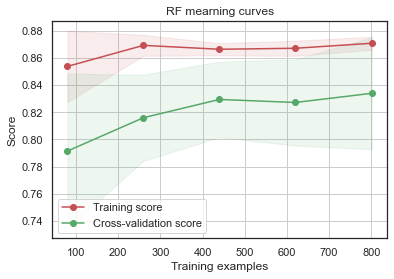

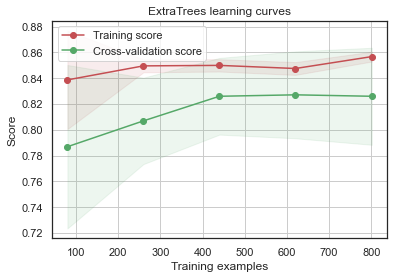

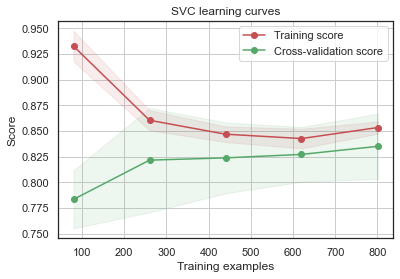

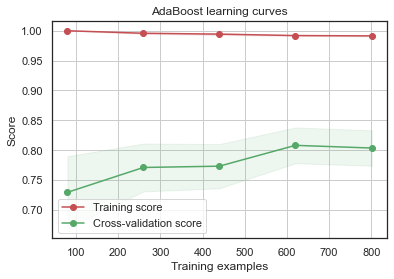

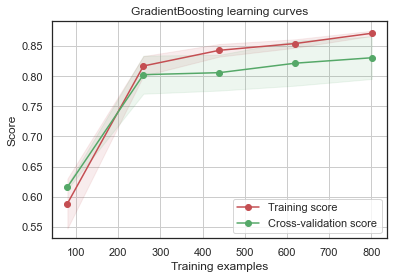

In [72]:
def plot_learning_curve(estimator, title, X, y, ylim=None, cv=None,
                        n_jobs=-1, train_sizes=np.linspace(.1, 1.0, 5)):
    """Generate a simple plot of the test and training learning curve"""
    plt.figure()
    plt.title(title)
    if ylim is not None:
        plt.ylim(*ylim)
    plt.xlabel("Training examples")
    plt.ylabel("Score")
    train_sizes, train_scores, test_scores = learning_curve(
        estimator, X, y, cv=cv, n_jobs=n_jobs, train_sizes=train_sizes)
    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)
    plt.grid()

    plt.fill_between(train_sizes, train_scores_mean - train_scores_std,
                     train_scores_mean + train_scores_std, alpha=0.1,
                     color="r")
    plt.fill_between(train_sizes, test_scores_mean - test_scores_std,
                     test_scores_mean + test_scores_std, alpha=0.1, color="g")
    plt.plot(train_sizes, train_scores_mean, 'o-', color="r",
             label="Training score")
    plt.plot(train_sizes, test_scores_mean, 'o-', color="g",
             label="Cross-validation score")

    plt.legend(loc="best")
    return plt

g = plot_learning_curve(gsRFC.best_estimator_,"RF mearning curves",X_train,Y_train,cv=kfold)
g = plot_learning_curve(gsExtC.best_estimator_,"ExtraTrees learning curves",X_train,Y_train,cv=kfold)
g = plot_learning_curve(gsSVMC.best_estimator_,"SVC learning curves",X_train,Y_train,cv=kfold)
g = plot_learning_curve(gsadaDTC.best_estimator_,"AdaBoost learning curves",X_train,Y_train,cv=kfold)
g = plot_learning_curve(gsGBC.best_estimator_,"GradientBoosting learning curves",X_train,Y_train,cv=kfold)

- GradientBoosting, Adaboost는 과적합 하는 경향이 있음. 하지만, 훈련 사이즈가 크면, 과적합 가능성이 줄어듬.

- SVC, ExtraTrees는 일반화가 잘된 것 같음.

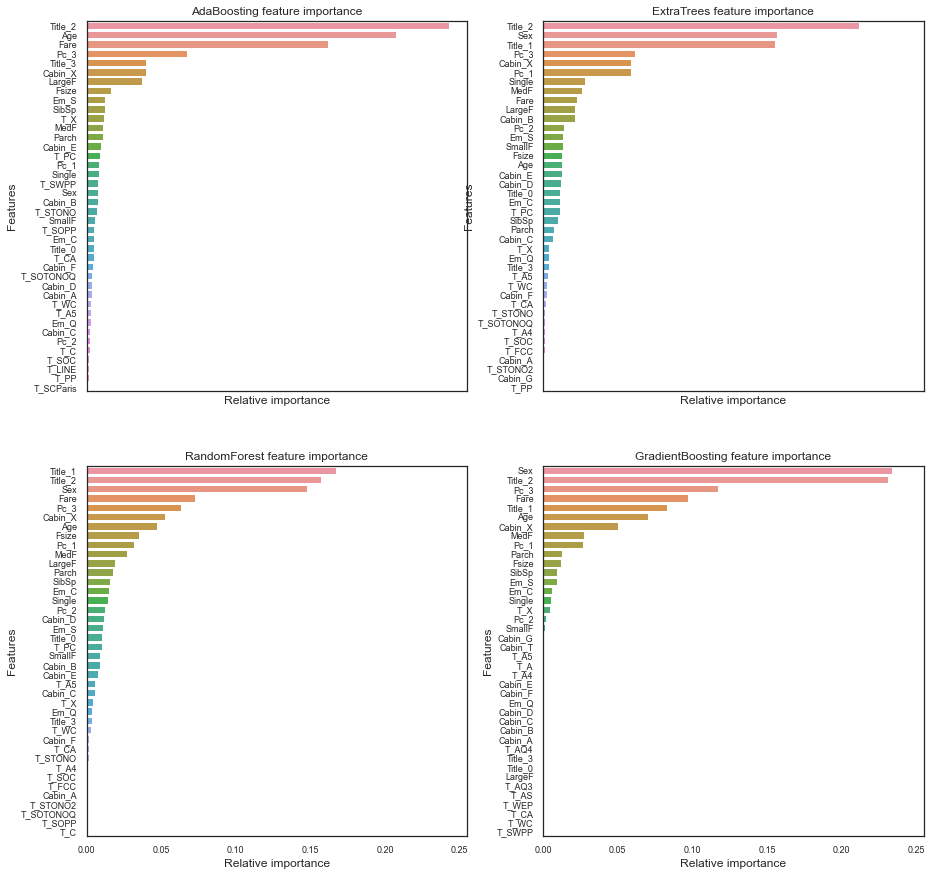

In [73]:
nrows = ncols = 2
fig, axes = plt.subplots(nrows = nrows, ncols = ncols, sharex="all", figsize=(15,15))

names_classifiers = [("AdaBoosting", ada_best),("ExtraTrees",ExtC_best),("RandomForest",RFC_best),("GradientBoosting",GBC_best)]

nclassifier = 0
for row in range(nrows):
    for col in range(ncols):
        name = names_classifiers[nclassifier][0]
        classifier = names_classifiers[nclassifier][1]
        indices = np.argsort(classifier.feature_importances_)[::-1][:40]
        g = sns.barplot(y=X_train.columns[indices][:40],x = classifier.feature_importances_[indices][:40] , orient='h',ax=axes[row][col])
        g.set_xlabel("Relative importance",fontsize=12)
        g.set_ylabel("Features",fontsize=12)
        g.tick_params(labelsize=9)
        g.set_title(name + " feature importance")
        nclassifier += 1

- Adaboost, ExtraTrees, RandomForest, GradientBoosting 4개의 모델에 대해서 feature importance를 확인

- feature importance의 순서는 모델마다 다름. 하지만 Fare, Title_2, Age, Sex는 공통적으로 상위권임.

- 특히 Title_2는 Mrs/Mlle/Mme/Miss/Ms에 대한 원핫인코딩인데, Sex와 높은 상관관계를 가지고 있음.

여기서는

- Pc_1, Pc_2, Pc_3, Fare은 승객의 사회적인 위치를 보여주고

- Sex, Title_2(Miss), Title_3(Mr)은 성별을 의미하고

- Age, Title_1(Master)는 승객의 나이를 의미하고

- Fsize, LargeF, MedF, Single은 가족 구성원 수를 의미함.

따라서

- 4가지 모델에 대한 feature importance를 봤을 때, 생존예측은 Age, Sex, family size, 사회적 지위에 더 영향이 많다는 것을 알 수 있음.

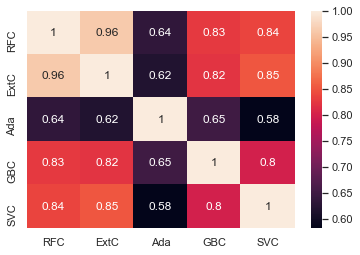

In [74]:
test_Survived_RFC = pd.Series(RFC_best.predict(test), name="RFC")
test_Survived_ExtC = pd.Series(ExtC_best.predict(test), name="ExtC")
test_Survived_SVMC = pd.Series(SVMC_best.predict(test), name="SVC")
test_Survived_AdaC = pd.Series(ada_best.predict(test), name="Ada")
test_Survived_GBC = pd.Series(GBC_best.predict(test), name="GBC")


# Concatenate all classifier results
ensemble_results = pd.concat([test_Survived_RFC,test_Survived_ExtC,test_Survived_AdaC,test_Survived_GBC, test_Survived_SVMC],axis=1)


g= sns.heatmap(ensemble_results.corr(),annot=True)

- Adaboost를 제외하고 나머지 모델들은 에측이 매우 유사함.

- 모델 모두 어느 정도 동일하게 예측하지만, 약간의 차이가 있음. 이러한 차이점을 이용해서 앙사아블 투표 분류기를 사용할 수 있음. 물론 스태킹도 가능.

## Ensemble modeling

### Combining models

In [75]:
votingC = VotingClassifier(estimators=[('rfc', RFC_best), ('extc', ExtC_best),
('svc', SVMC_best), ('adac',ada_best),('gbc',GBC_best)], voting='soft', n_jobs=4)

votingC = votingC.fit(X_train, Y_train)


## Prediction

### Predict and Submit results

In [76]:
test_Survived = pd.Series(votingC.predict(test), name="Survived")

results = pd.concat([IDtest,test_Survived],axis=1)

# results.to_csv("ensemble_python_voting.csv",index=False)